## COVID-19 Spread : exploratory analysis

<font size="3">**Coronavirus disease (COVID-19)** is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing.


In this notebook exploratory analysis of spread of covid-19 is studied and which will help to determine which factors impact the transmission behavior of COVID-19. 
Right now this notebook examines covid-19 spread based on the following datasets through visualisations. Though it does not consider some key factors such as 

1. asymptomatic spread,
2. Climatic factors

I will update this notebook to consider the above information and models to forecast spread. (some kernels have implemented some of them)
<br/><br/>

STAY SAFE.

<font size="5">**DATA EXPLORATION**</font>


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
sns.set(style="white", color_codes=True)

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# We will use - 'corona-virus-report', 'novel-corona-virus-2019-dataset' 

In [5]:
import os
print(os.listdir("."))
# for item in os.listdir("../input/"):
#     print(os.listdir(f'../input/{item}'))

['.ipynb_checkpoints', 'file2.html', 'covid-19-spread-analysis-visualisation.ipynb', 'index.html', 'input']


<font size="4">**Reading and understanding the data**</font>

In [6]:
table1 = pd.read_csv('./input/covid_19_data.csv', parse_dates=['ObservationDate'])
print(table1.shape)
table1.head(2)

(11930, 8)


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0


In [7]:
table2 = pd.read_csv('./input/covid19countryinfo.csv', thousands=',')
print(table2.shape)
table2.head(3)

(249, 60)


,region,country,alpha3code,alpha2code,pop,tests,testpop,density,medianage,urbanpop,...,newdeaths2,newdeaths3,recovered,critical30,critical31,critical1,critical2,critical3,casediv1m,deathdiv1m
0,NaN,Afghanistan,AFG,AF,38928346.0,NaN,NaN,60.0,18.0,25.0,...,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,7.0,0.2
1,NaN,Albania,ALB,AL,2877797.0,NaN,NaN,105.0,36.0,63.0,...,1.0,NaN,89.0,7.0,8.0,7.0,7.0,7.0,106.0,6.0
2,NaN,Algeria,DZA,DZ,43851044.0,NaN,NaN,18.0,29.0,73.0,...,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,22.0,2.0


<font size="4">**Preparing the data** </font>

> TABLE1 DATA 

In [8]:
#PREPRARING TABLE1 DATA
table1 = table1.dropna(axis=0, how='all')
table1 = table1.drop(['SNo'], axis=1)

# Renaming Mainland china as China in the data table
table1['Country/Region'] = table1['Country/Region'].replace('Mainland China', 'China')
table1 = table1.rename(columns={'ObservationDate':'Date', 'Country/Region':'country'})

cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case: Active Case = confirmed - deaths - recovered
table1['Active'] = table1['Confirmed'] - table1['Deaths'] - table1['Recovered']

# filling missing values 
table1[['Province/State']] = table1[['Province/State']].fillna('')
table1[cases] = table1[cases].fillna(0)

# latest
table1_latest = table1[table1['Date'] == max(table1['Date'])].reset_index()
# latest_reduced
table1_latest_gp = table1_latest.groupby('country')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
table1.tail(2)

,Date,Province/State,country,Last Update,Confirmed,Deaths,Recovered,Active
11928,2020-04-04,Yunnan,China,2020-04-04 23:41:02,184.0,2.0,172.0,10.0
11929,2020-04-04,Zhejiang,China,2020-04-04 23:41:02,1262.0,1.0,1229.0,32.0


> TABLE2 DATA

In [9]:
# PREPARING TABLE2 DATA

table2 = table2.dropna(axis=0, how='all')
# table2 = table2.dropna(axis=1, thresh=len(table2)*0.20) # selecting columns with atleast 20% non-nan values

print(table2.shape)
country_info = table2[table2['region'] != table2['region']].drop(['region', 'alpha3code', 'alpha2code', 'newcases30','newcases31','deaths','newdeaths30','newdeaths31','recovered','critical30','critical31', 'active30', 'active31'], axis=1)
# table2[(table2['quarantine'] == table2['quarantine']) & (table2['region'] != table2['region'])][['country', 'quarantine']]

# country_info[['healthexp', 'totalcases']].apply(pd.to_numeric)
country_info.head(2)

(249, 60)


,country,pop,tests,testpop,density,medianage,urbanpop,quarantine,schools,publicplace,...,newcases2,newcases3,newdeaths1,newdeaths2,newdeaths3,critical1,critical2,critical3,casediv1m,deathdiv1m
0,Afghanistan,38928346.0,NaN,NaN,60.0,18.0,25.0,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,0.2
1,Albania,2877797.0,NaN,NaN,105.0,36.0,63.0,NaN,NaN,NaN,...,18.0,27.0,NaN,1.0,NaN,7.0,7.0,7.0,106.0,6.0


**1. Maximum number of cases from country**



In [10]:
# temp = table1.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered', 'Active'].max().reset_index()
# temp[temp['Confirmed'] == max(temp['Confirmed'])]

# OR
temp = table1_latest_gp[table1_latest_gp['Confirmed'] == max(table1_latest_gp['Confirmed'])]
print(temp['country'])
temp

172    US
Name: country, dtype: object


,country,Confirmed,Deaths,Recovered,Active
172,US,308850.0,8407.0,14652.0,285791.0


**2. Total Global cases**

In [11]:
temp = table1.groupby('Date')['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
temp = temp[temp['Date']==max(temp['Date'])].reset_index(drop=True)
(temp.style.background_gradient(cmap='Pastel1'))

,Date,Confirmed,Deaths,Recovered,Active
0,2020-04-04 00:00:00,1.19740e+06,64606,246152,886647


In [12]:
temp_f = table1_latest_gp.sort_values(by='Confirmed', ascending=False)
temp_f = temp_f.reset_index(drop=True)[:20]
temp_f.style.background_gradient(cmap='Reds')

,country,Confirmed,Deaths,Recovered,Active
0,US,308850,8407,14652,285791
1,Spain,126168,11947,34219,80002
2,Italy,124632,15362,20996,88274
3,Germany,96092,1444,26400,68248
4,France,90848,7574,15572,67702
5,China,81638,3326,76763,1549
6,Iran,55743,3452,19736,32555
7,UK,42477,4320,215,37942
8,Turkey,23934,501,786,22647
9,Switzerland,20505,666,6415,13424


<font size="5">**Data Visualisation**</font>

## 1.Trend analysis

**Visual 1 :** A Time-series graph of the confirmed and recovered cases of COVID-19. This shows that with increasing number of positive cases the number of recovered cases as a whole also increasing telling us that the situation is improving.

1. The rate of increase of confirmed cases significantly drops from March 1st week and almost flattens.
2. We expect the bar of **recovered cases** to increase in coming weeks to compensate the total number of positive cases and neutralise the situation.

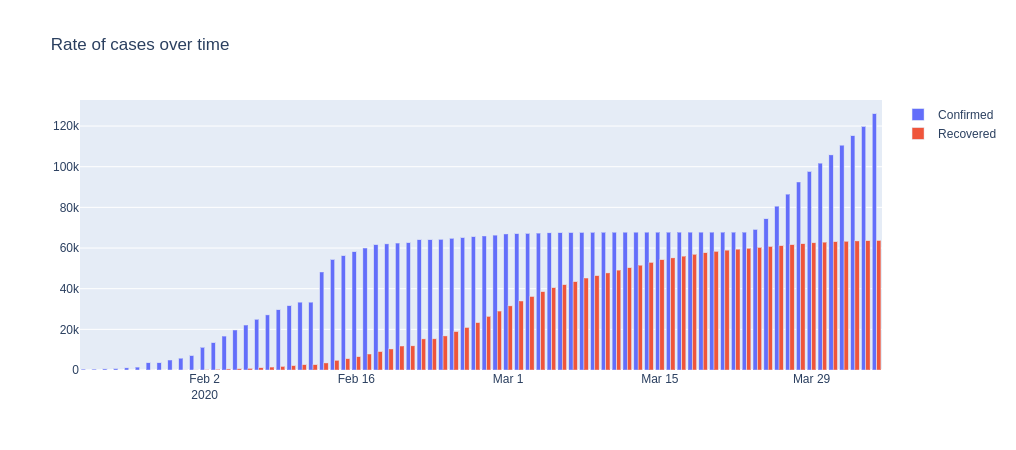

In [119]:
import plotly as py
import plotly.graph_objects as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# init_notebook_mode(connected=True)
temp = table1.groupby('Date').max().reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(
                x=temp['Date'],
                y=temp['Confirmed'],
                name="Confirmed",))

fig.add_trace(go.Bar(
                x=temp['Date'],
                y=temp['Recovered'],
                name="Recovered",))
fig.update_layout(title_text='Rate of cases over time')
py.offline.iplot(fig)
fig.write_image("global_CR.png",scale=1, width=800, height=420)

**Visual 2 :** Total confirmed, recovered, active cases.

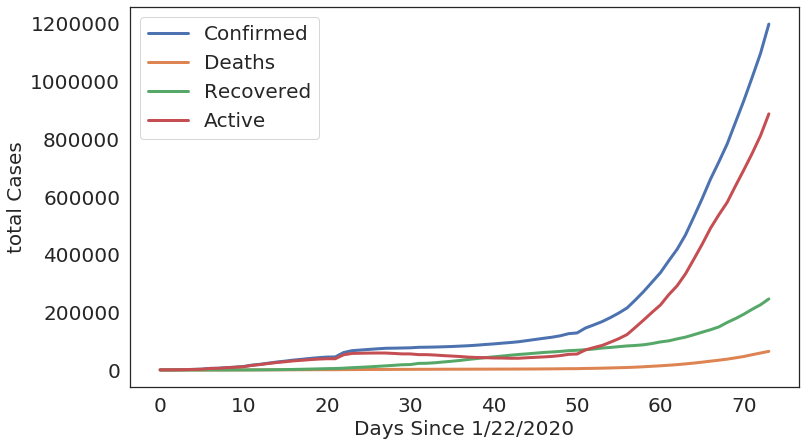

In [26]:
fig = plt.figure(figsize=(12, 7))
# ax = plt.subplot(111)
plt.plot(table1.groupby('Date').sum().reset_index()[cases], linewidth=3)
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('total Cases', size=20)
plt.legend(cases, prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()
fig.savefig('global_CARD.png', bbox_inches='tight')

**Visual 3 :** Trend for top 5 most spread countries

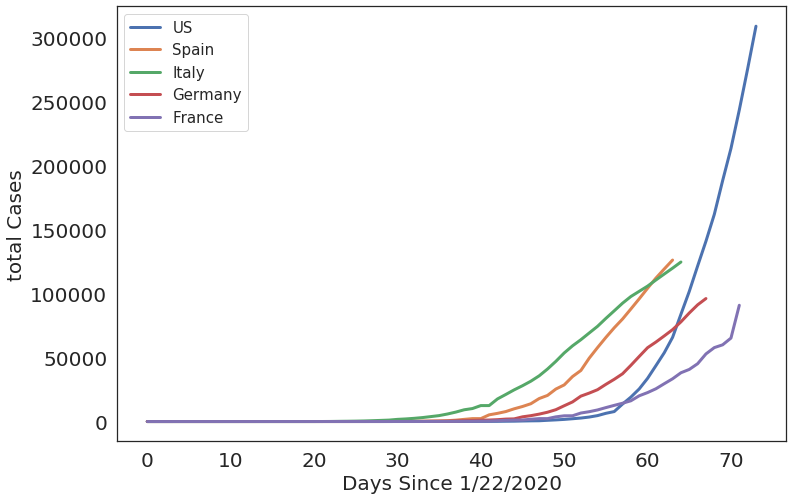

In [27]:
top_5 = list(temp_f['country'][:5])
fig = plt.figure(figsize=(12,8))
plt.plot(table1[table1['country'] == top_5[0]].groupby('Date').sum().reset_index()['Confirmed'], linewidth=3)
plt.plot(table1[table1['country'] == top_5[1]].groupby('Date').sum().reset_index()['Confirmed'], linewidth=3)
plt.plot(table1[table1['country'] == top_5[2]].groupby('Date').sum().reset_index()['Confirmed'], linewidth=3)
plt.plot(table1[table1['country'] == top_5[3]].groupby('Date').sum().reset_index()['Confirmed'], linewidth=3)
plt.plot(table1[table1['country'] == top_5[4]].groupby('Date').sum().reset_index()['Confirmed'], linewidth=3)
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('total Cases', size=20)
plt.legend(top_5, prop={'size': 15})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()
fig.savefig('country_C.png', bbox_inches='tight')

**Visual 4 :** Plot for mortality and recovery rates.

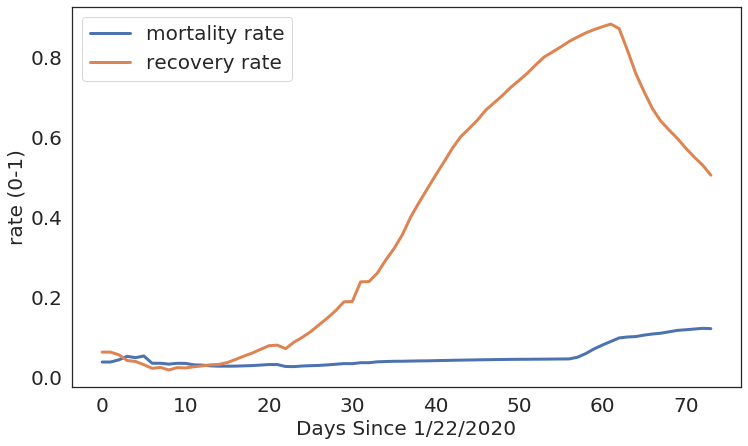

In [28]:
temp = table1.groupby('Date').max().reset_index()
dates = temp.keys()
mortality_rate = []
recovery_rate = [] 

for i,row in temp.iterrows():
    confirmed_sum = temp.iloc[i]['Confirmed']
    death_sum = temp.iloc[i]['Deaths']
    recovered_sum = temp.iloc[i]['Recovered']

    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)


fig = plt.figure(figsize=(12, 7))
plt.plot(mortality_rate, linewidth=3)
plt.plot(recovery_rate, linewidth=3)
plt.xlabel('Days Since 1/22/2020', size=20)
plt.ylabel('rate (0-1)', size=20)
plt.legend(['mortality rate', 'recovery rate'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()
fig.savefig('global_rate.png', bbox_inches='tight')

For the last week, there is a steep decline in recovery rate and a gradual increase in mortality rate. The possible reasons can be increase in number of cases.

**Visual 5 :** Plot for number of deaths and recoveries.

In [29]:
# TOP 10 COUNTRIES WITH MOST NUMBER OF DEATHS

temp_f = table1.groupby('country').max().reset_index()[['country','Deaths','Recovered']].sort_values('Deaths', ascending=False)[:10].reset_index(drop=True)
temp_f.style.background_gradient(cmap='Reds')

,country,Deaths,Recovered
0,Italy,15362,20996
1,Spain,11947,34219
2,France,7560,15438
3,UK,4313,135
4,US,3565,14652
5,Iran,3452,19736
6,China,3207,63762
7,Netherlands,1651,250
8,Germany,1444,26400
9,Belgium,1283,3247


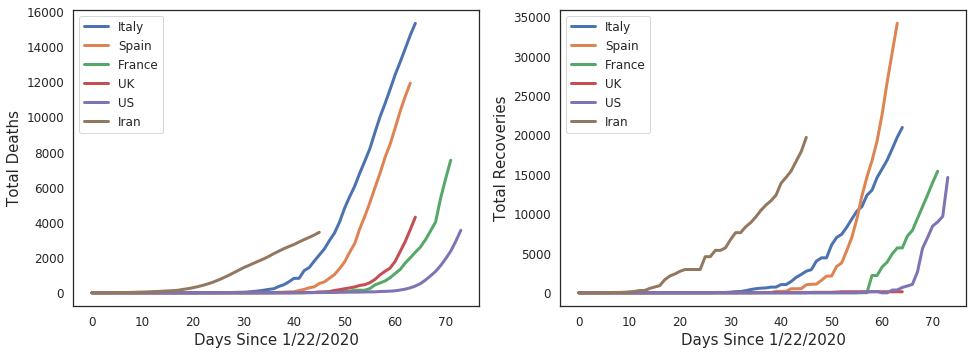

In [47]:
top_5 = temp_f['country'][:6]
temp = table1[table1['country'] == 'US'].groupby('Date').max().reset_index()

fig = plt.figure(figsize=(16,12))
# fig, ax = plt.subplots(1, 1)
ax = plt.subplot(2,2,1)
ax.plot(table1[table1['country'] == top_5[0]].groupby('Date').max().reset_index()['Deaths'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[1]].groupby('Date').max().reset_index()['Deaths'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[2]].groupby('Date').max().reset_index()['Deaths'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[3]].groupby('Date').max().reset_index()['Deaths'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[4]].groupby('Date').max().reset_index()['Deaths'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[5]].groupby('Date').max().reset_index()['Deaths'], linewidth=3)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('Total Deaths', size=15)
plt.legend(top_5, prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)

ax = plt.subplot(2,2,2)
ax.plot(table1[table1['country'] == top_5[0]].groupby('Date').max().reset_index()['Recovered'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[1]].groupby('Date').max().reset_index()['Recovered'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[2]].groupby('Date').max().reset_index()['Recovered'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[3]].groupby('Date').max().reset_index()['Recovered'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[4]].groupby('Date').max().reset_index()['Recovered'], linewidth=3)
ax.plot(table1[table1['country'] == top_5[5]].groupby('Date').max().reset_index()['Recovered'], linewidth=3)
plt.xlabel('Days Since 1/22/2020', size=15)
plt.ylabel('Total Recoveries', size=15)
plt.legend(top_5, prop={'size': 12})
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()
fig.savefig('country_RD.png', bbox_inches='tight')

From plot, it is visible that Italy and Spain has a sudden increase in number of deaths. US despite having a largest number of cases and France also following the same trend.

## 2. Effect of population density, healthcare system

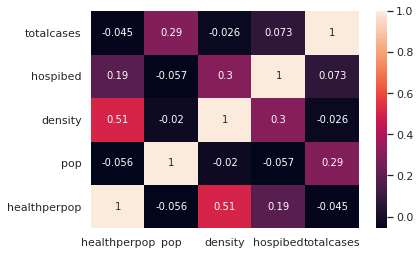

In [113]:
"""
@temp1 - subset of country_info for population, density, and healthcare related data against total cases, deaths.
"""

temp1 = country_info[['country','healthperpop', 'pop' , 'density','hospibed', 'totalcases']].sort_values(by='totalcases', ascending=False)
temp1 = temp1.reset_index(drop=True)

temp1.style.bar(subset=['healthperpop', 'totalcases', 'urbanpop'], align='mid', color=['#d65f5f', '#5fba7d'])
# print(country_info['healthperpop'].mean())

ax = sns.heatmap(temp1.corr(), annot=True);
ax.set_ylim([0,5]);

fig = ax.get_figure()
fig.savefig('corr1.png', bbox_inches='tight')

There is some amount of correlation between the total cases and the total population (0.29), which actually justifies itself.

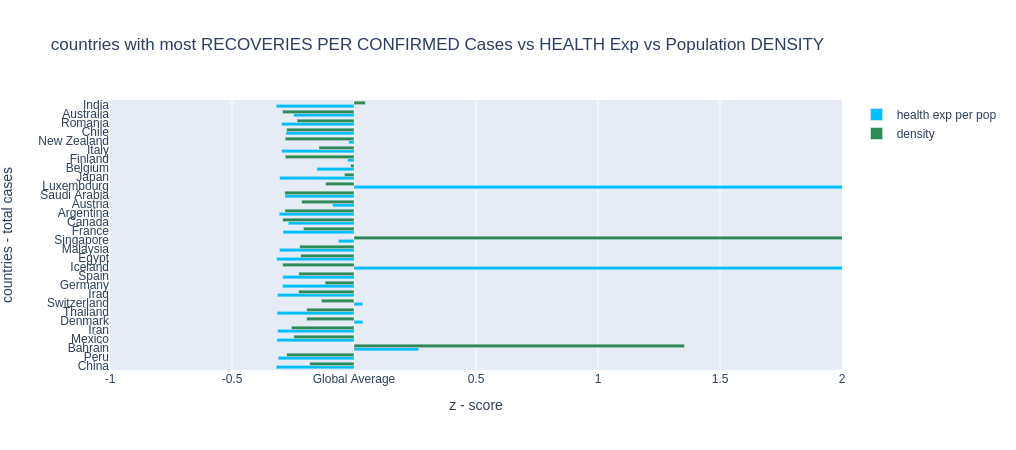

In [115]:
temp1 = pd.merge(country_info[['country','healthperpop', 'density','hospibed', 'totalcases']], table1[['country', 'Recovered']]\
                 .groupby('country').max(), on='country').sort_values(by='Recovered', ascending=False)
temp1 = temp1.reset_index(drop=True)
temp1 = temp1[:40]

temp1['recover_per_confirmed'] = temp1['Recovered']/temp1['totalcases']
temp1 = temp1.sort_values('recover_per_confirmed', ascending=False)[1:].reset_index(drop=True)

x = temp1['healthperpop']
x2 = temp1['density']
temp1['healthperpop_z'] = (x - x.mean())/x.std()
temp1['density_z'] = (x2 - x2.mean())/x2.std()

fig = go.Figure()
fig.add_trace(go.Bar(y=temp1.loc[:29, ['country']].values.reshape(30),
               x=np.array(temp1.loc[:29, ['healthperpop_z']]).reshape(30),
               orientation='h',
               name='health exp per pop',
               hoverinfo='x',
               marker=dict(color='deepskyblue'),
               width=0.4
               ))

fig.add_trace(go.Bar(y=temp1.loc[:29, ['country']].values.reshape(30),
               x=np.array(temp1.loc[:29, ['density_z']]).reshape(30),
               orientation='h',
               name='density',
               hoverinfo='x',
               marker=dict(color='seagreen'),
               width=0.4  
               ))
fig.update_layout(title = 'countries with most RECOVERIES PER CONFIRMED Cases vs HEALTH Exp vs Population DENSITY',
                  yaxis=go.layout.YAxis(title_text='countries - total cases', tickvals=temp1.loc[:29, ['country']].values.reshape(30)),
                  xaxis=go.layout.XAxis(
                       range = [-1, 2.0],
                       tickvals = [-1, -0.5, 0, 0.5, 1.5, 1, 2],
                       ticktext = [-1, -0.5, 'Global Average', 0.5, 1.5, 1, 2],
                       title = 'z - score'),
#                   barmode='overlay',
                  bargap=0.3)
py.offline.iplot(fig);
fig.write_image("global_density_healthexp.png",scale=1.2)
# py.offline.plot(fig, filename='file.html');

From the plot, it can be understood that almost all countries has 

## 3. Effect of age vs Deaths

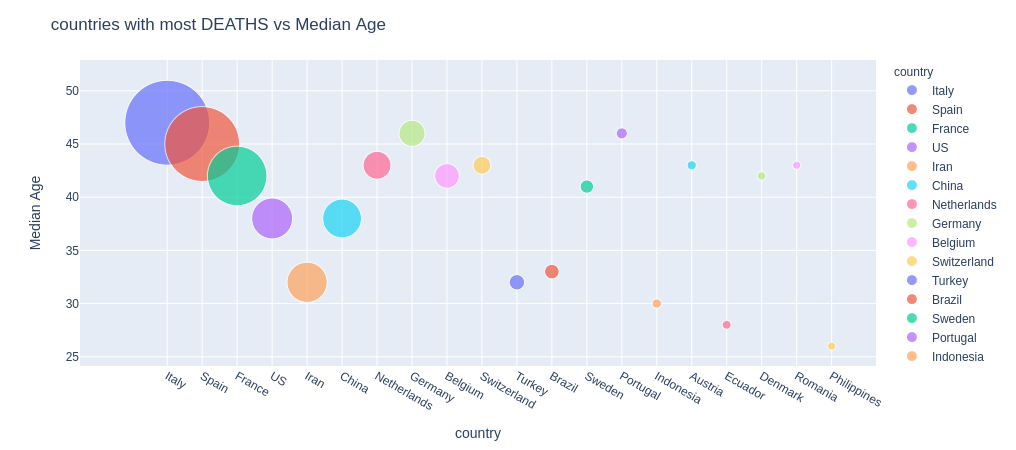

In [118]:
country_age = pd.merge(country_info[['country', 'medianage', 'sexratio']], table1[['country', 'Deaths']].groupby('country').max(), on='country')
country_age = country_age.sort_values(by='Deaths', ascending=False)[:20]
# temp3[temp3['country'] == 'India']

fig = px.scatter(country_age, x="country", y="medianage", size="Deaths", 
                 color="country", hover_name="country", size_max=60)

fig.update_layout(title_text='countries with most DEATHS vs Median Age',
                  yaxis=go.layout.YAxis(title_text='Median Age',
#                                         tickvals = [-1, 0, 1, 2, 3, 4],
#                                         ticktext = [-1, 'Global Average', 1, 2, 3, 4],
                                       ),
                   xaxis=go.layout.XAxis(title_text='Countries with incoming rate (high -> low)')
                 )

fig.show();


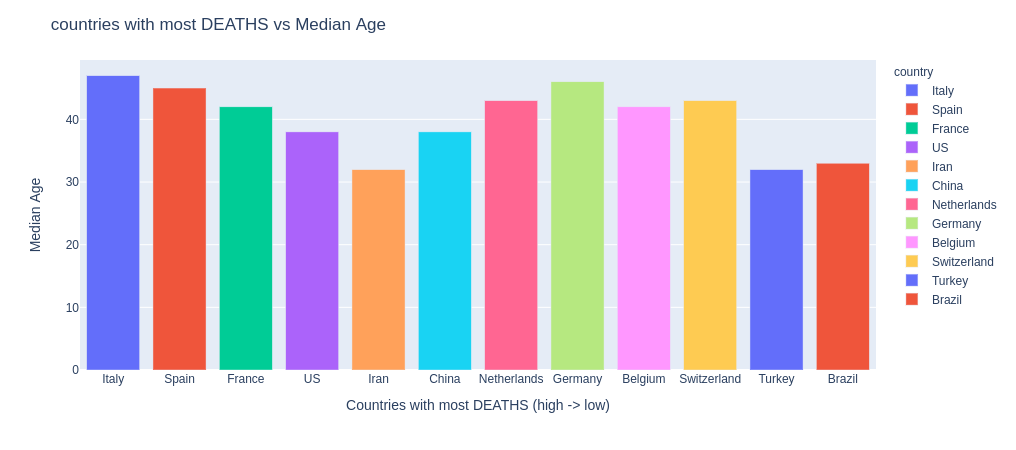

In [161]:
fig = px.bar(country_age[:12], x="country", y="medianage", color="country")

fig.update_layout(title_text='countries with most DEATHS vs Median Age',
                  yaxis=go.layout.YAxis(title_text='Median Age'),
                   xaxis=go.layout.XAxis(title_text='Countries with most DEATHS (high -> low)')
                 )

fig.show();
fig.write_image("deathVSage.png",scale=1, width=800, height=420)

## 4. Effect of travel and tourist pattern of countries vs Total Cases

In [124]:
global_inbound = pd.read_excel('./input/global_travel_inbound.xls', header=3)
global_inbound = global_inbound.dropna(how='all', axis=1)

indeces = global_inbound.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis=1).dropna(how='all', axis=0).index
global_inbound = global_inbound.iloc[indeces].reset_index(drop=True)

# Renaming column to similar column names
global_inbound = global_inbound.rename(columns={'Country Name':'country'})
# Changing United States to 'US' o maintain similarity
global_inbound.loc[global_inbound['country']=='United States', 'country'] = 'US'

In [139]:
temp = pd.merge(global_inbound, country_info, on='country').reset_index(drop=True)
temp = temp[['country', 'totalcases', 'firstcase', 'quarantine', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018']]

temp = temp.sort_values('totalcases', ascending=False)[:20]

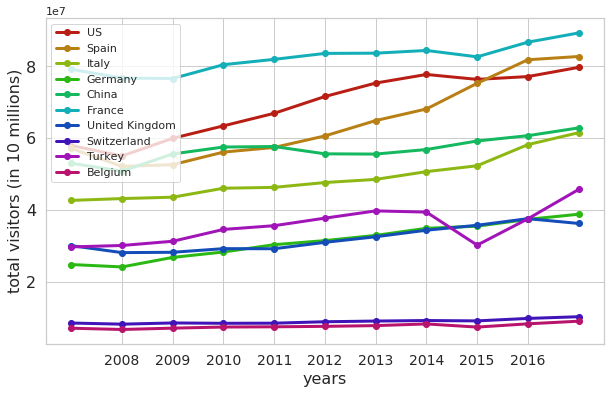

In [152]:
with sns.axes_style("whitegrid"):
    
    fig = plt.figure(figsize=(10,6))
    plot=list()
    color_palette = sns.hls_palette(temp[:10].shape[0], l=.4, s=.8)
    for i in range(temp[:10].shape[0]):
        plt.plot(temp[[ '2008', '2009', '2010', '2011', '2012', '2013','2014', '2015', '2016', '2017', '2018']].iloc[i].values,
                 color=color_palette[i], label=temp.iloc[i]['country'], linewidth=3, marker='o')

plt.legend(handles = plot, labels = list(temp['country'][:10].values))    
plt.xlabel('years', size=16)
plt.ylabel('total visitors (in 10 millions)', size=16)
plt.xticks(list(range(1,10)), labels=[ '2008', '2009', '2010', '2011', '2012', '2013','2014', '2015', '2016', '2017', '2018'], size=14)
plt.yticks(size=16)
plt.show()

fig.savefig('visitors_2018.png', bbox_inches='tight')

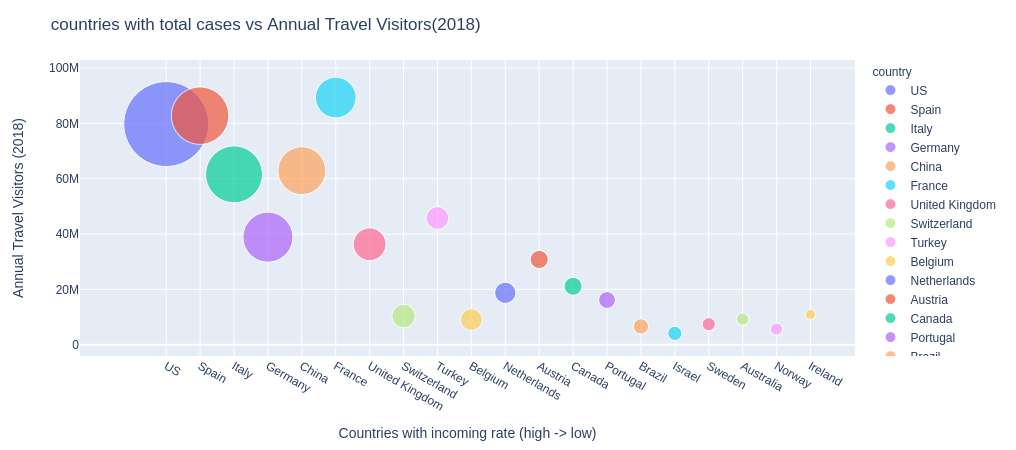

In [153]:
fig = px.scatter(temp, x="country", y="2018", size="totalcases", 
                 color="country", hover_name="country", size_max=60)

fig.update_layout(title_text='countries with total cases vs Annual Travel Visitors(2018)',
                  yaxis=go.layout.YAxis(title_text='Annual Travel Visitors (2018)',
#                                         tickvals = [-1, 0, 1, 2, 3, 4],
#                                         ticktext = [-1, 'Global Average', 1, 2, 3, 4],
                                       ),
                  xaxis=go.layout.XAxis(title_text='Countries with incoming rate (high -> low)')
                 )
fig.show();
fig.write_image("countriesVSvisitors.png",scale=1, width=800, height=420)

In [127]:
china_travel = pd.read_excel('./input/china_outbound.xlsx', header=5)
china_travel = china_travel.dropna(how='all', axis=1)

indeces = china_travel.drop(['country'], axis=1).dropna(how='all', axis=0).index
china_travel = china_travel.iloc[indeces].reset_index(drop=True)

china_travel.loc[china_travel['country']=='Korea, Republic of', 'country'] = 'Korea, South'
china_travel.loc[china_travel['country']=='United States of America', 'country'] = 'US'
china_travel.shape

(235, 27)

In [128]:
china_travel_top20 = china_travel.groupby('country').sum().sort_values(by=2018, ascending=False).reset_index()[:40]

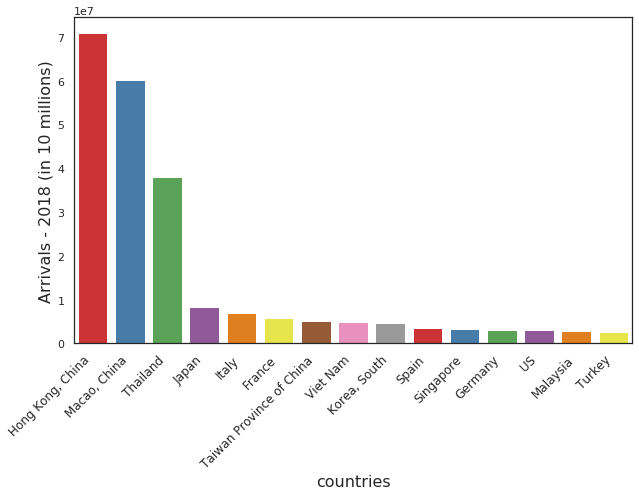

In [141]:
plt.figure(figsize=(10,6))
fig = sns.barplot(x='country', y=2018, data=china_travel_top20[:15], palette='Set1')

# plt.legend(handles = plot, labels = list(temp['country'][:10].values))    
plt.xlabel('countries', size=16)
plt.ylabel('Arrivals - 2018 (in 10 millions)', size=16)
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right', size=12)
plt.show()

fig = fig.get_figure()
fig.savefig('chineese_2018.png', bbox_inches='tight')

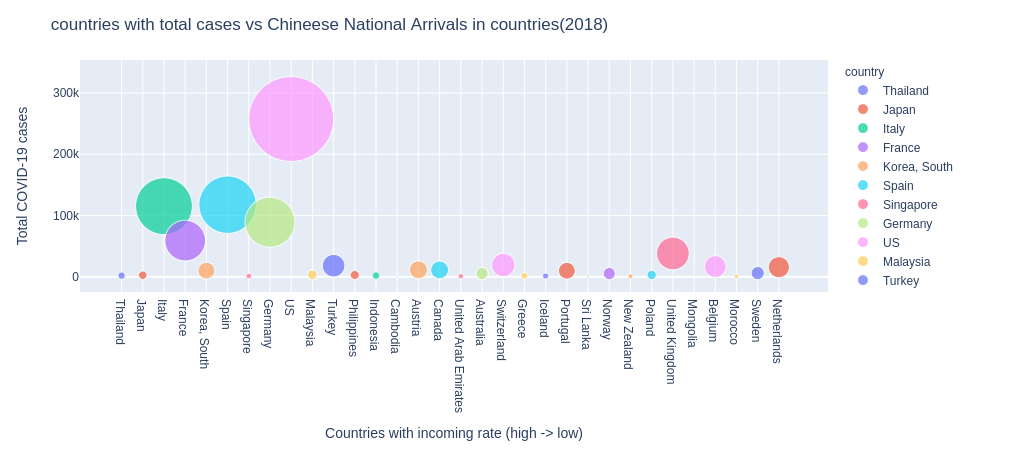

In [129]:
# temp4 = pd.merge(temp[['country', '2018']], table1[['country', 'Deaths']].groupby('country').max(), on='country')
# temp4 = temp4.sort_values(by='Deaths', ascending=False)[:20]

temp = pd.merge(china_travel_top20, country_info, on='country').reset_index(drop=True)
temp = temp.sort_values(2018, ascending=False)

fig = px.scatter(temp, x="country", y='totalcases', size='totalcases', 
                 color="country", hover_name="country", size_max=60)

fig.update_layout(title_text='countries with total cases vs Chineese National Arrivals in countries(2018)',
                  yaxis=go.layout.YAxis(title_text='Total COVID-19 cases',
#                                         tickvals = [-1, 0, 1, 2, 3, 4],
#                                         ticktext = [-1, 'Global Average', 1, 2, 3, 4],
                                       ),
                  xaxis=go.layout.XAxis(title_text='Countries with incoming rate (high -> low)')
                 )
fig.show();
fig.write_image("countriesVScases_chineese.png",scale=1, width=800, height=420)

## 5. Effect of tests conducted on Total Cases, recovered cases

In [130]:
country_tests = table2.loc[:,['country','pop','tests', 'gatheringlimit']]

In [131]:
continents = pd.read_csv("./input/countryContinent.csv", encoding='latin-1')
continents = continents.loc[:,['country','continent']]

In [132]:
continents['continent'].value_counts()

Africa      58
Americas    55
Asia        51
Europe      51
Oceania     25
Name: continent, dtype: int64

In [166]:
tests_merged = pd.merge(table1[['country', 'Confirmed', 'Deaths', 'Recovered', 'Active']].groupby('country').max(), country_tests, on='country')
tests_merged = pd.merge(tests_merged, continents, on='country', how='left')

tests_merged.loc[tests_merged.country=='Russia','continent'] = 'Europe'
tests_merged.loc[tests_merged.country=='US','continent'] = 'Americas'
tests_merged.loc[tests_merged.country=='Vietnam','continent'] = 'Asia'

tests_merged_notna = tests_merged[['country','pop','Deaths', 'Confirmed', 'Recovered', 'tests', 'continent']].dropna(how='any', axis=0)\
.reset_index(drop=True)

In [167]:
tests_merged_notna['tests_1m'] = round(1000000*tests_merged_notna.tests/tests_merged_notna['pop'],2)
tests_merged_notna['Confirmed_1m'] = round(1000000*tests_merged.Confirmed/tests_merged_notna['pop'],2)
tests_merged_notna['Deaths_1m'] = round(1000000*tests_merged.Deaths/tests_merged_notna['pop'],2)
tests_merged_notna['Recovered_1m'] = round(1000000*tests_merged.Recovered/tests_merged_notna['pop'],2)

In [173]:
tests_merged_notna.head(2)
tests_merged_notna[tests_merged_notna['country'] == 'India']

,country,pop,Deaths,Confirmed,Recovered,tests,continent,tests_1m,Confirmed_1m,Deaths_1m,Recovered_1m
18,India,1.380004e+09,86.0,3082.0,229.0,5900.0,Asia,4.28,0.0,0.0,0.0


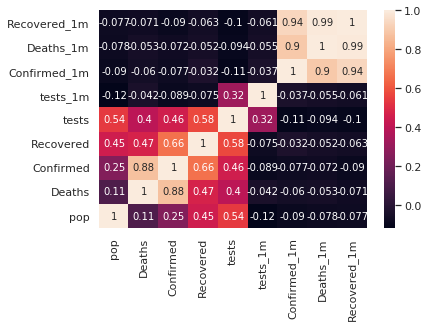

In [170]:
ax=sns.heatmap(tests_merged_notna.corr(), annot=True);
ax.set_ylim([0,9]);
fig = ax.get_figure()
fig.savefig('corr2.png', bbox_inches='tight')

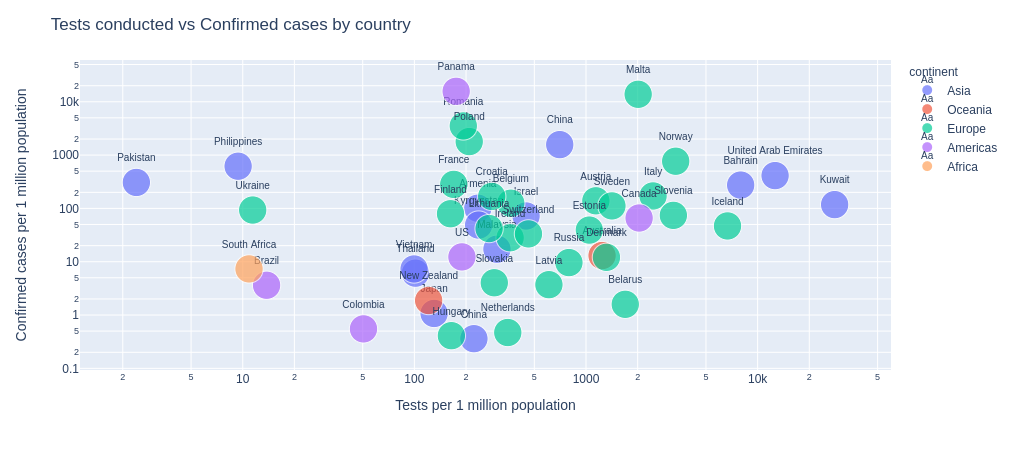

In [137]:
tests_merged_notna['size'] = 20
fig = px.scatter(tests_merged_notna, x='tests_1m', y='Confirmed_1m',  size='size',text='country', color='continent')\
.update_traces(textposition='top center', textfont_size=10)\
.update_layout(title='Tests conducted vs Confirmed cases by country', xaxis_type='log', yaxis_type='log', xaxis_title='Tests per 1 million population', yaxis_title='Confirmed cases per 1 million population')
fig.show()
fig.write_image("countriesVStestsVSpopulation.png",scale=1, width=800, height=420)

As said earlier, the strongest correlation (although not absolutely strong) for the number of test cases is with the number of recovered people. This makes some sense - if the availability of tests helps the countries to identify the infected people earlier, so a proper care could be imposed at the earlier disease stages.